In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

# Цели и задачи проекта:
### Провести разведывательный анализ данных и выявить условия жизни учащихся от 15 до 22 лет влияющие на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [2]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [3]:
# подгужаем наши данные в ДФ
stud = pd.read_csv('C:/Users/A.Frolov/stud_math.csv')

In [4]:
# Функции для обработки данных:

# Функция фильтрации выбросов для числовых значений
def perset(df, column):
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)

    print(
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        "IQR: {}, ".format(IQR),
        "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

    a = df[column].max()
    b = df[column].min()

    df[column].loc[df[column].between(
        perc25 - 1.5*IQR,
        perc75 + 1.5*IQR)].hist(bins=5, range=(b, a), label='IQR')

    df[column].loc[df[column] <= a].hist(
        alpha=0.5, bins=5, range=(b, a), label='Выбросы')

    plt.legend()


# Функция которая пробегает по не числовому столбцу
# и если есть пустые значения заменяет их на None для дальнейшего анализа (чтоб не думать об этом)
def blowout(df, column):
    df[column] = df[column].astype(str).apply(
        lambda x: None if x.strip() == '' else x)

# Функция определяет корреляцию между числовыми значениями


def corril(df, column):
    display(df[['score', column]].corr())
    sns.pairplot(df[['score', column]], kind='reg')
    a = df['score'].corr(df[column])
    if a == 0 or a == 1:
        print('Данные либо совпадают, либо полностью не связаны. В расчет не идет')
    elif 0 < a < 0.5:
        print('Зависимость прямая, но слабая')
    elif 0.5 < a < 1:
        print('Зависимость прямая, стоит обратить внимание')
    elif -0.5 < a < 0:
        print('Зависимость обратная, но слабая')
    elif -1 < a < -0.5:
        print('Зависимость обратная, стоит обратить внимание')
    else:
        print('Не правильное значение')


# функция визуализирует различаются ли распределения успеваемости в зависимости от значения переменных
# для визуального анализа номинативных переменных
def get_boxplot(df, column):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(x=column, y='score',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# Названия всех столбцов
all = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'studytime, granular', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'bsences', 'score']


# Функция проверяющая статистическую разницу в распределении успеваемости по номинативным признакам
def get_stat_dif(df, column):
    cols = df.loc[:, column].value_counts().index[:100]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return
    print('Не найдены статистически значимые различия для колонки', column)


# Функция определения типа колонки и дальнейшего анализа
def statist(df, column):
    if df[column].dtypes == float:
        display(pd.DataFrame(df[column].value_counts()))
        df.loc[:, [column]].info()
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        print('Распределение числового столбца')
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        df[column].hist()
        perset(df, column)
        corril(df, column)

    elif df[column].dtypes == object:
        df.loc[:, [column]].info()
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        print('Номинативные переменные')
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
       # blowout(df,column)
        get_boxplot(df, column)
        get_stat_dif(df, column)

    elif df[column].dtypes == 'int64':
        display(pd.DataFrame(df[column].value_counts()))
        df.loc[:, [column]].info()
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        print('Распределение числового столбца')
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        df[column].hist()
        perset(df, column)
        corril(df, column)

    else:
        datatypes = df[column].dtypes
        print('Колона типа' + datatypes)

In [5]:
# Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [6]:
# Так как будущие оценки будут по успеваимости (цель анализа), то сразу выкинем из датасета пропуски столбца успеваемости
stud = stud[stud.score.notnull()]

In [7]:
# Посмотрим, сколько оценок и каких содержит наш датасет
pd.DataFrame(stud.score.value_counts())

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
60.0,31
40.0,31
45.0,27
70.0,27
80.0,16


25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


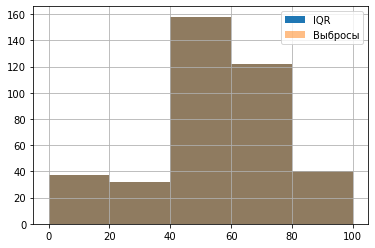

In [8]:
# Посмотрим нет ли выбросов в самом столбце score
perset(stud, 'score')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  389 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


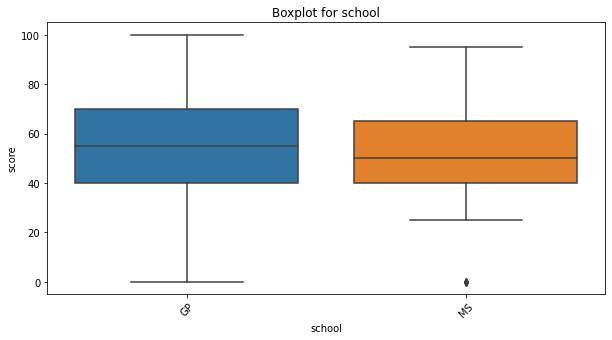

Не найдены статистически значимые различия для колонки school
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     389 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


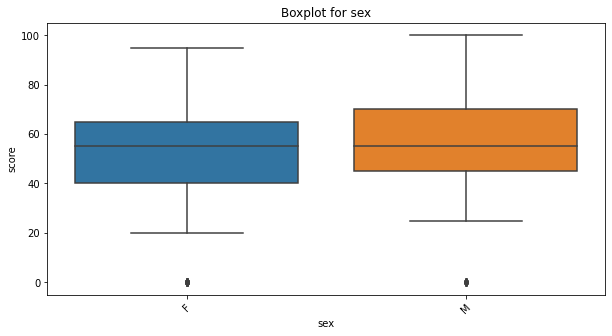

Не найдены статистически значимые различия для колонки sex


,age
16,103
17,98
15,82
18,80
19,21
20,3
21,1
22,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     389 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].


,score,age
score,1.000000,-0.155726
age,-0.155726,1.000000


Зависимость обратная, но слабая
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  374 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


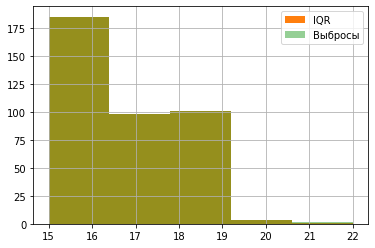

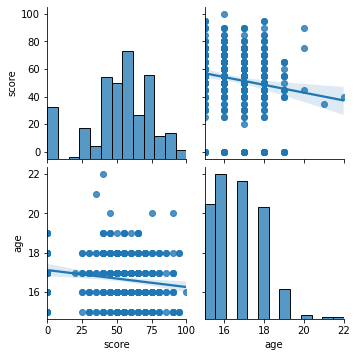

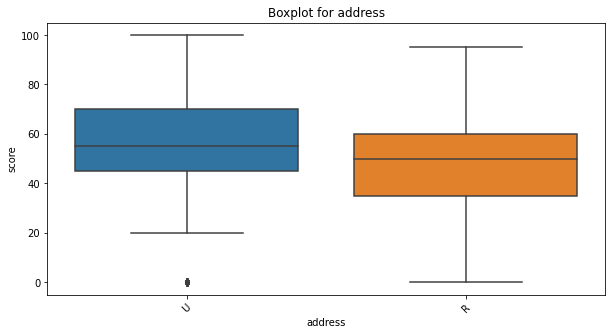

Найдены статистически значимые различия для колонки address
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  362 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


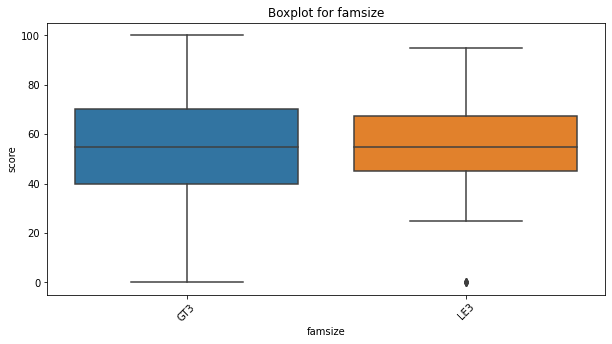

Не найдены статистически значимые различия для колонки famsize
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pstatus  344 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


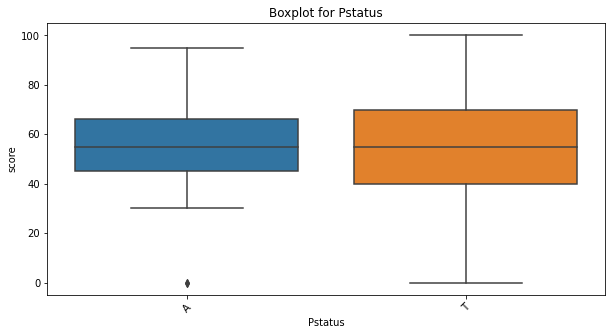

Не найдены статистически значимые различия для колонки Pstatus


,Medu
4.0,131
2.0,100
3.0,96
1.0,56
0.0,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Medu    386 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


,score,Medu
score,1.000000,0.213349
Medu,0.213349,1.000000


Зависимость прямая, но слабая


,Fedu
2.0,105
3.0,94
4.0,88
1.0,75
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fedu    365 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


,score,Fedu
score,1.000000,0.078573
Fedu,0.078573,1.000000


Зависимость прямая, но слабая
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Mjob    370 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


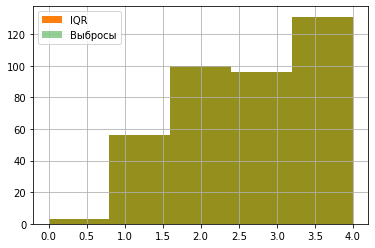

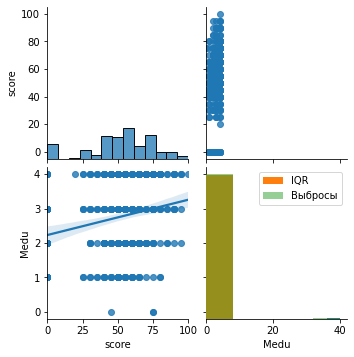

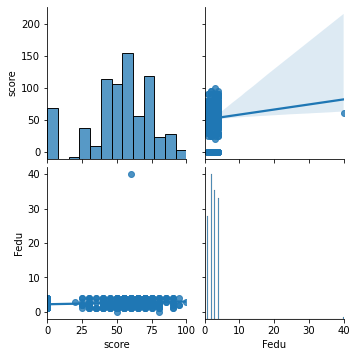

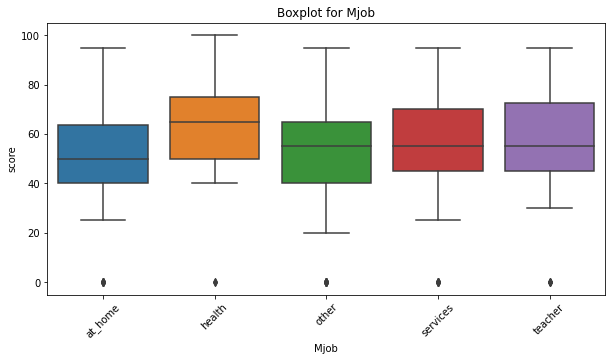

Найдены статистически значимые различия для колонки Mjob
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Fjob    353 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


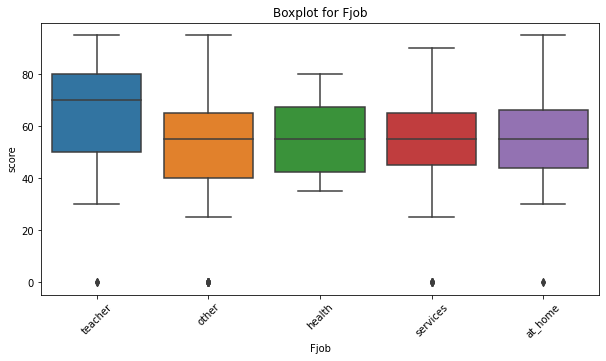

Не найдены статистически значимые различия для колонки Fjob
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  372 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


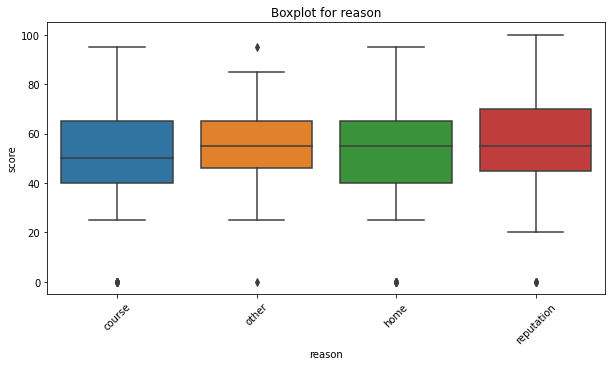

Не найдены статистически значимые различия для колонки reason
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  358 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


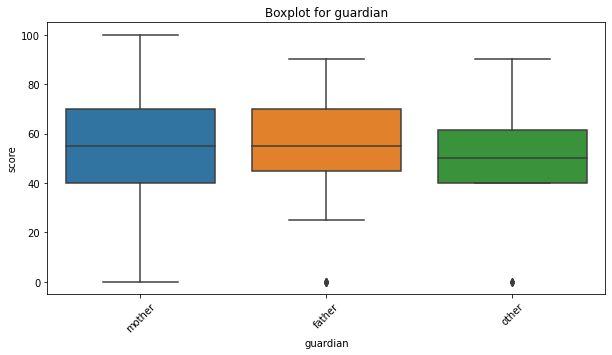

Не найдены статистически значимые различия для колонки guardian


,traveltime
1.0,239
2.0,94
3.0,21
4.0,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  361 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


,score,traveltime
score,1.000000,-0.070559
traveltime,-0.070559,1.000000


Зависимость обратная, но слабая


,studytime
2.0,189
1.0,103
3.0,63
4.0,27


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  382 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


,score,studytime
score,1.000000,0.115741
studytime,0.115741,1.000000


Зависимость прямая, но слабая


,failures
0.0,290
1.0,48
2.0,15
3.0,14


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  367 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


,score,failures
score,1.000000,-0.344338
failures,-0.344338,1.000000


Зависимость обратная, но слабая
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  380 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


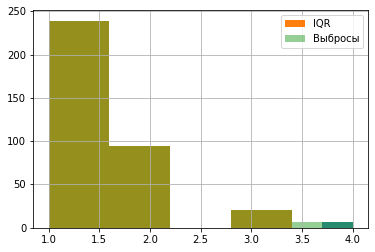

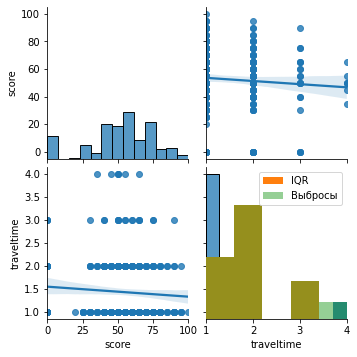

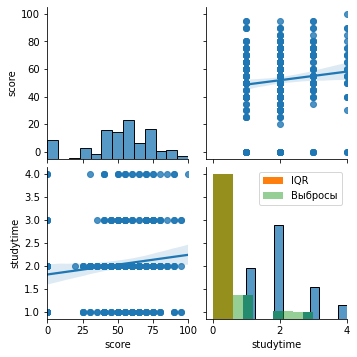

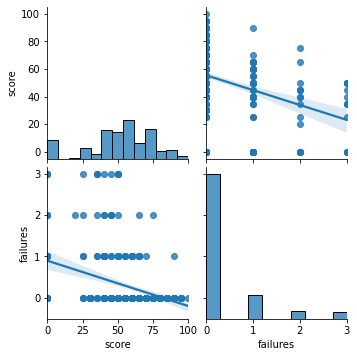

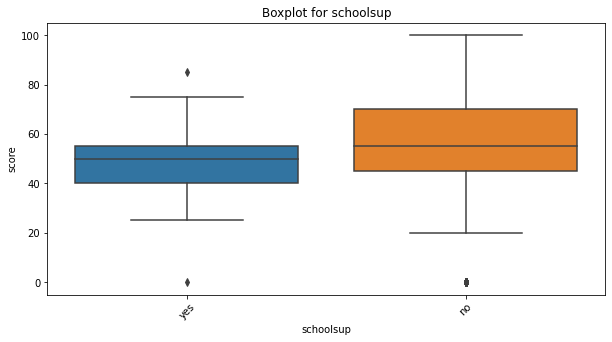

Не найдены статистически значимые различия для колонки schoolsup
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  351 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


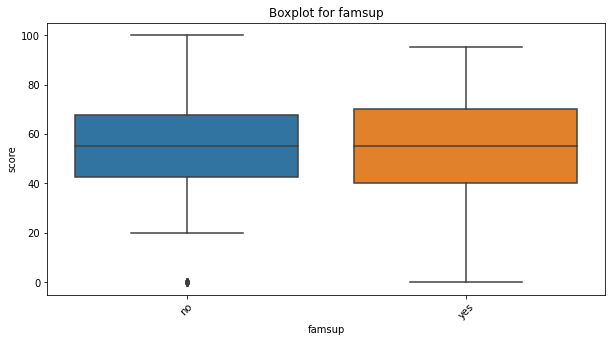

Не найдены статистически значимые различия для колонки famsup
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    350 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


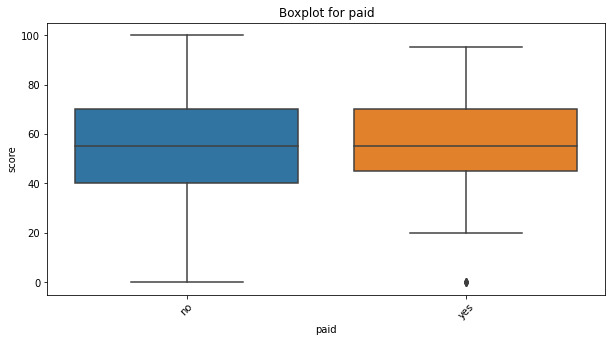

Не найдены статистически значимые различия для колонки paid
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  375 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


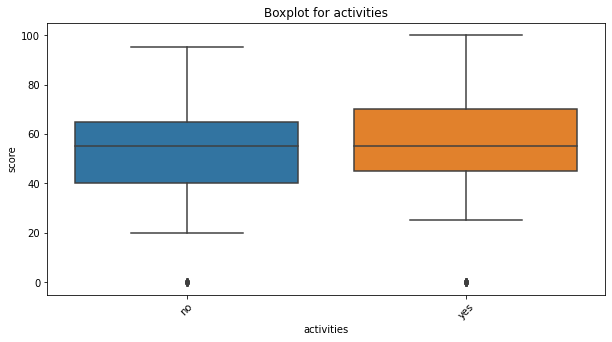

Не найдены статистически значимые различия для колонки activities
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  374 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


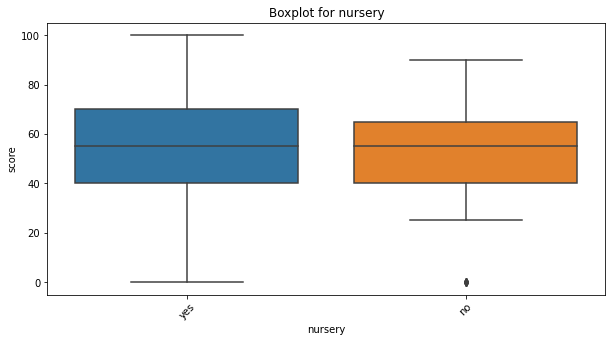

Не найдены статистически значимые различия для колонки nursery


,"studytime, granular"
-6.0,189
-3.0,103
-9.0,63
-12.0,27


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studytime, granular  382 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: -6.0, 75-й перцентиль: -3.0, IQR: 3.0,  Границы выбросов: [-10.5, 1.5].


,score,"studytime, granular"
score,1.000000,-0.115741
"studytime, granular",-0.115741,1.000000


Зависимость обратная, но слабая
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  369 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


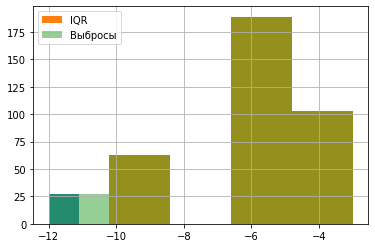

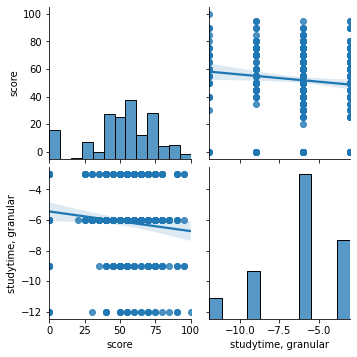

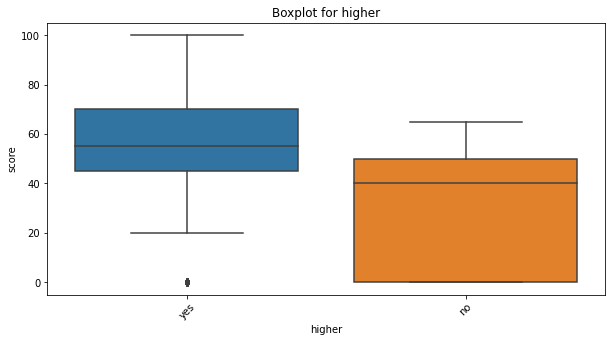

Найдены статистически значимые различия для колонки higher
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  355 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


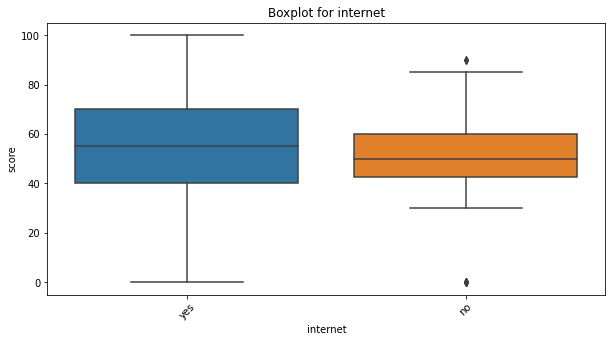

Не найдены статистически значимые различия для колонки internet
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  358 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Номинативные переменные
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


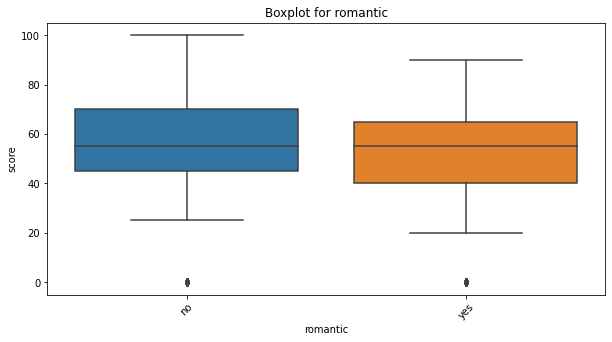

Найдены статистически значимые различия для колонки romantic


,famrel
4.0,178
5.0,97
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  362 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].


,score,famrel
score,1.000000,0.057112
famrel,0.057112,1.000000


Зависимость прямая, но слабая


,freetime
3.0,152
4.0,110
2.0,63
5.0,37
1.0,18


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  380 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].


,score,freetime
score,1.000000,0.019026
freetime,0.019026,1.000000


Зависимость прямая, но слабая


,goout
3.0,126
2.0,101
4.0,81
5.0,51
1.0,23


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   382 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


,score,goout
score,1.000000,-0.129685
goout,-0.129685,1.000000


Зависимость обратная, но слабая


,health
5.0,137
3.0,88
4.0,60
1.0,47
2.0,42


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  374 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


,score,health
score,1.00000,-0.07046
health,-0.07046,1.00000


Зависимость обратная, но слабая


,absences
0.0,110
2.0,60
4.0,52
6.0,30
8.0,20
10.0,17
14.0,12
12.0,12
16.0,7
3.0,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  378 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Распределение числового столбца
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


,score,absences
score,1.000000,0.065283
absences,0.065283,1.000000


Зависимость прямая, но слабая


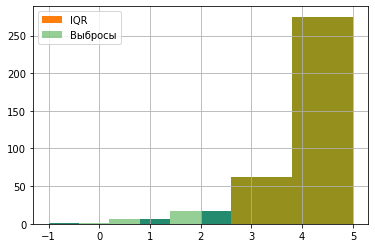

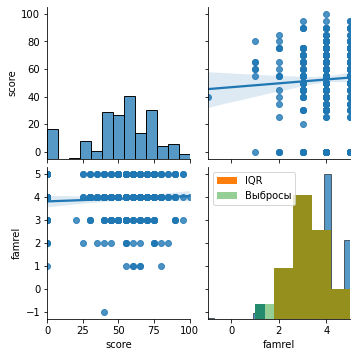

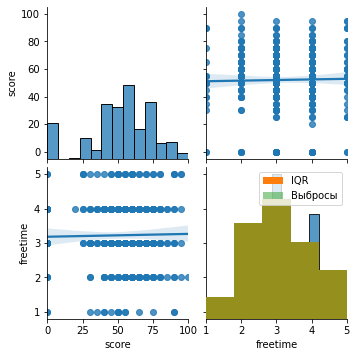

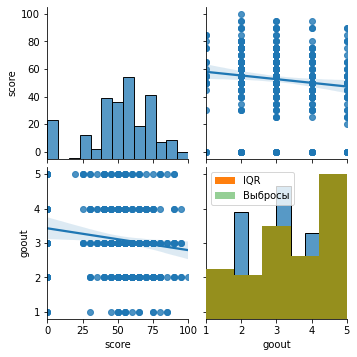

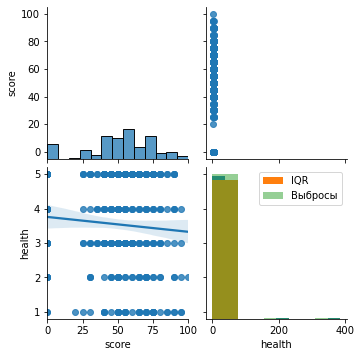

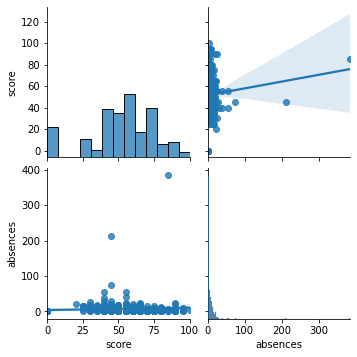

In [9]:
for all in ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
            'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
            'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
            'activities', 'nursery', 'studytime, granular', 'higher',
            'internet', 'romantic', 'famrel', 'freetime', 'goout',
            'health', 'absences']:
    statist(stud, all)

In [10]:
# Важные переменные, которые, возможно, оказывают влияние на успеваемость, это: address, Mjob, higher, romantic, Medu и failures
stud_for_model = stud.loc[:, ['address', 'Mjob',
                              'higher', 'romantic', 'Medu', 'failures']]
stud_for_model

,address,Mjob,higher,romantic,Medu,failures
0,U,at_home,yes,no,4.0,0.0
1,U,at_home,yes,no,1.0,0.0
2,U,at_home,yes,NaN,1.0,3.0
3,U,health,yes,yes,4.0,0.0
4,U,other,yes,no,3.0,0.0
...,...,...,...,...,...,...
390,U,services,yes,no,2.0,2.0
391,U,services,yes,no,3.0,0.0
392,R,other,NaN,no,1.0,3.0
393,R,services,yes,no,3.0,0.0


# Выводы:
### 1) В данных нет пустых значений и довольно не много пропусков
### 2) Сразу избавились от пустых данных в столбце score так как именно по нему и велся анализ. Их было не много, 389 из 394 были нормальные.
### 3) В некоторых столбцах есть выбросы (например traveltime), но их не много.
### 4) Есть столбец не описанный в задании (studytime, granular), но он ни на что не влияет и его можно выкинуть.
### 5) В столбце score нету выбросов, значит можно его анализировать. Значене 0 в оценках кажется странным, но там слишком много потенциально реальных значений (37), так что оставляем их для анализа.
### 6) Есть и положительная и отрицательная корреляция с столбцом score, но они почти все незначительны, кроме Medu(0.21) и failures(-0.34).
### 7) Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это address, Mjob, higher, romantic, а  также Medu и failures (последние два могут означать что чем больше неудач, тем хуже оценка или чем лучше образование матери, тем лучше успеваемость)